# Surface Water Mapping with Monte Carlo Dropout

This notebook demonstrates surface water mapping using a trained U-Net model and Monte Carlo dropout for uncertainty estimation.

The workflow includes:

1. Loading a trained model
2. Running deterministic predictions
3. Performing Monte Carlo dropout inference
4. Visualizing prediction uncertainty

All paths are defined relative to the project root to ensure reproducibility.


### 1. Import libraries
This section imports the required Python packages, model architectures, and dataset utilities used throughout the notebook.

In [ ]:
import sys
from pathlib import Path

# Add parent directory to Python path to import src modules
PROJECT_ROOT = Path("..").resolve()
sys.path.append(str(PROJECT_ROOT))

# Standard libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Project modules
from src.models.unet import UNet
from src.models.unet_plus import UNetPlusPlus
from src.dataset.dataset import SegDataset
from src.dataset.utils import get_transform
from src.train import (
    criterion,
    get_metrics,
    get_device,
    set_seed,
    configure_deterministic_behavior,
)


## 2. Define project paths

All paths are defined relative to the repository root.  
Adjust `PROJECT_ROOT` if running the notebook from a different location.

In [ ]:
# Project root (assumes notebook is inside the repo)
PROJECT_ROOT = Path(".").resolve()

DATASET = "s1"           # "s1" or "s2"
DATASET_TYPE = "zscore"

TEST_PATH = PROJECT_ROOT / f"data/patches/{DATASET}/{DATASET_TYPE}/test"
MODEL_PATH = PROJECT_ROOT / f"models/{DATASET}_unet.pth"

## 3. Monte Carlo Dropout model wrapper

This class enables **Monte Carlo dropout inference** by:

- Replacing dropout layers with a configurable rate
- Performing multiple stochastic forward passes
- Returning the **mean prediction** and **predictive standard deviation**

This allows estimation of **pixel-wise uncertainty**.

In [ ]:
class MonteCarloDropout(nn.Module):
    def __init__(self, model, num_forward_passes=10, dropout_rate=0.5):
        super().__init__()
        self.model = model
        self.num_forward_passes = num_forward_passes
        self.device = next(model.parameters()).device
        self._replace_dropout_layers(self.model, dropout_rate)

    def _replace_dropout_layers(self, module, rate):
        for name, child in module.named_children():
            if isinstance(child, nn.Dropout):
                setattr(module, name, nn.Dropout(p=rate))
            else:
                self._replace_dropout_layers(child, rate)

    def _set_dropout_train_mode(self, mode=True):
        for layer in self.model.modules():
            if isinstance(layer, nn.Dropout):
                layer.train(mode)

    def _freeze_batchnorm(self):
        for module in self.model.modules():
            if isinstance(module, nn.BatchNorm2d):
                module.eval()

    def forward(self, x):
        x = x.to(self.device)
        was_training = self.model.training

        self.model.train()
        self._set_dropout_train_mode(True)
        self._freeze_batchnorm()

        with torch.no_grad():
            outputs = torch.stack(
                [self.model(x) for _ in range(self.num_forward_passes)], dim=0
            )

        if not was_training:
            self.model.eval()

        outputs = torch.sigmoid(outputs)
        return outputs.mean(dim=0), outputs.std(dim=0)


## 4. Load test dataset

We load the prepared test patches from the dataset.  
Each sample contains:

- Multi-band satellite input
- Corresponding binary water mask

In [ ]:
test_dataset = SegDataset(
    dataset_type=DATASET,
    path=TEST_PATH,
    transform=None,
    slope=True,
    s1_ratio=False,
)

## 5. Deterministic prediction and Monte Carlo inference

For a randomly selected test patch:

1. Run a deterministic prediction
2. Perform Monte Carlo dropout inference
3. Evaluate different dropout rates
4. Visualize mean prediction and uncertainty

/tmp/ipykernel_167855/2849505773.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))
/home/fs70533/mabdelaa/.local/lib/python3.

Dropout Rate: 0.0


/tmp/ipykernel_167855/2849505773.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH))


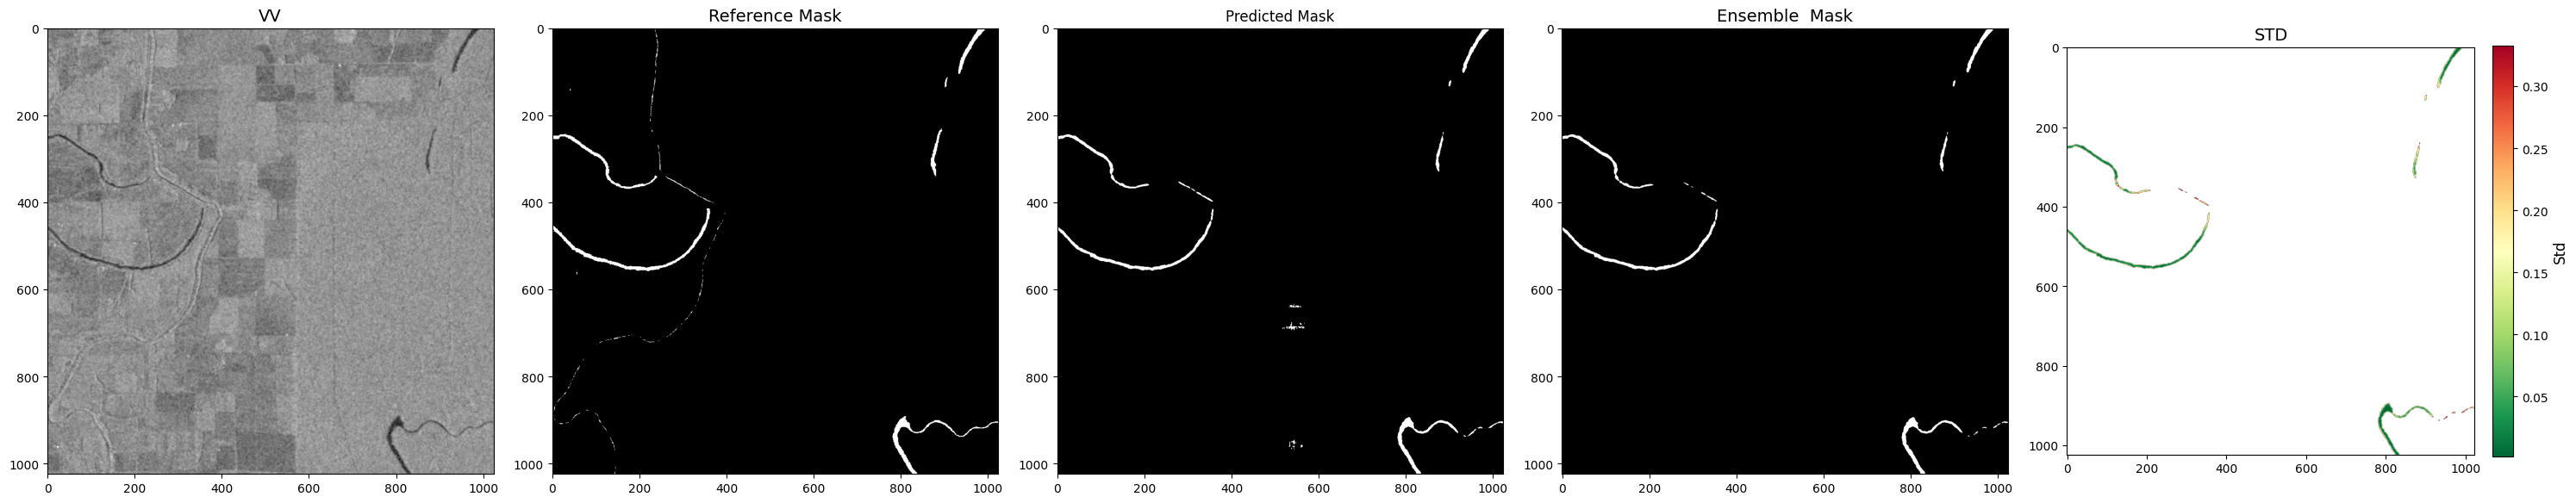

Dropout Rate: 0.05


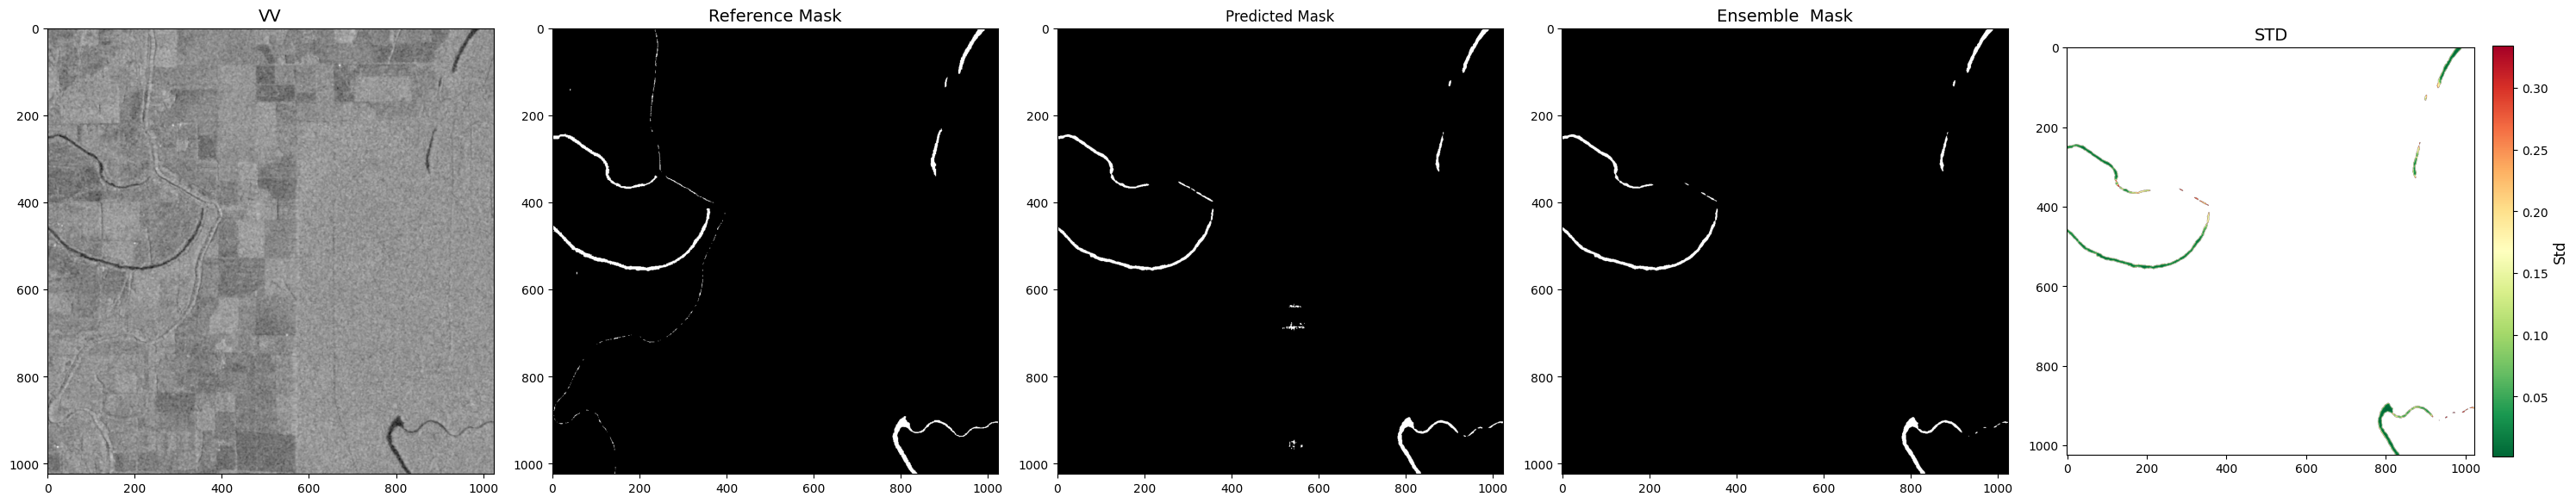

Dropout Rate: 0.1


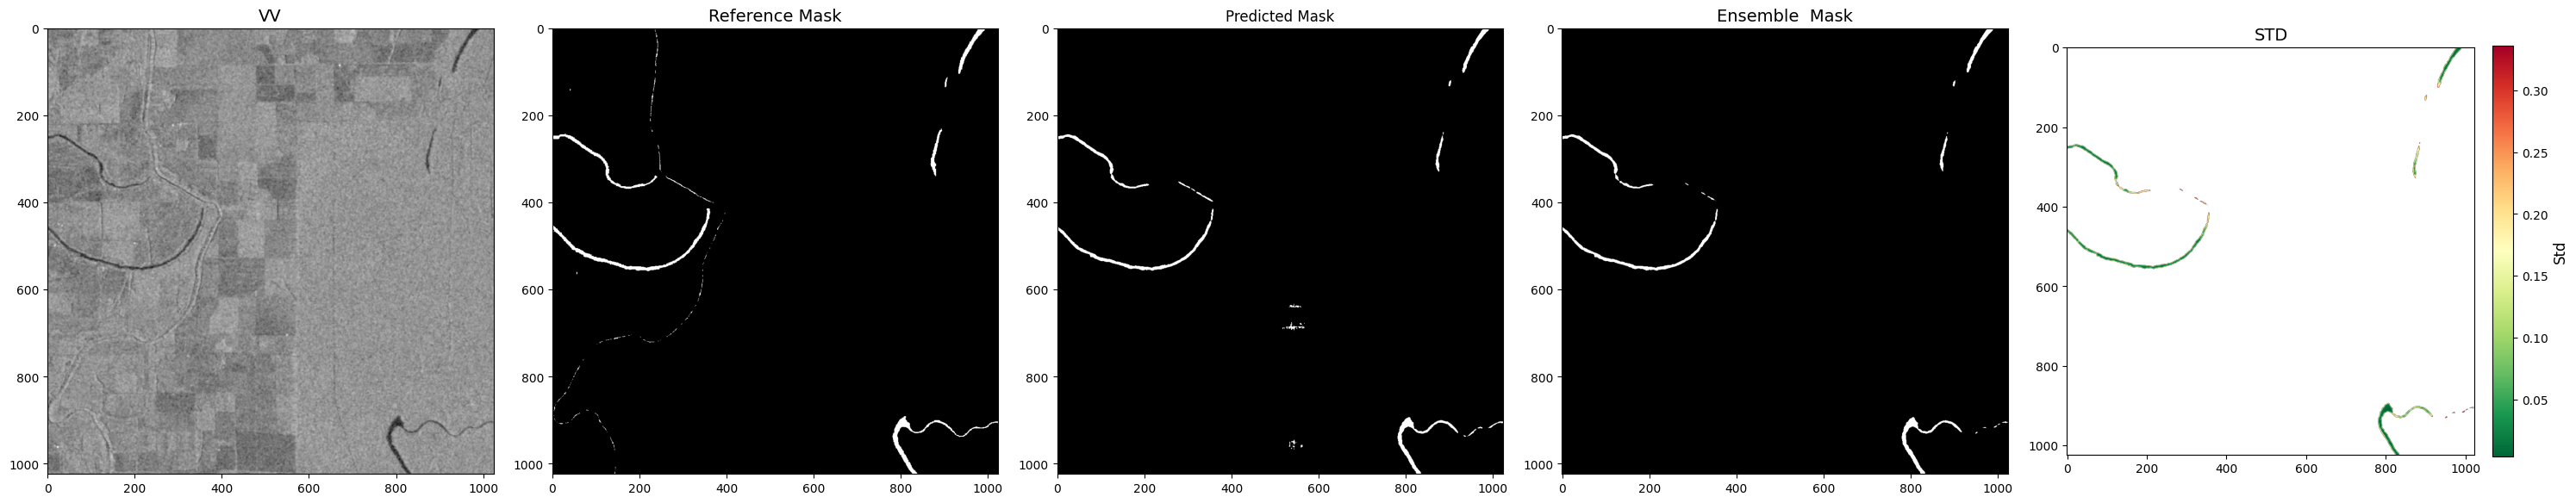

Dropout Rate: 0.15000000000000002


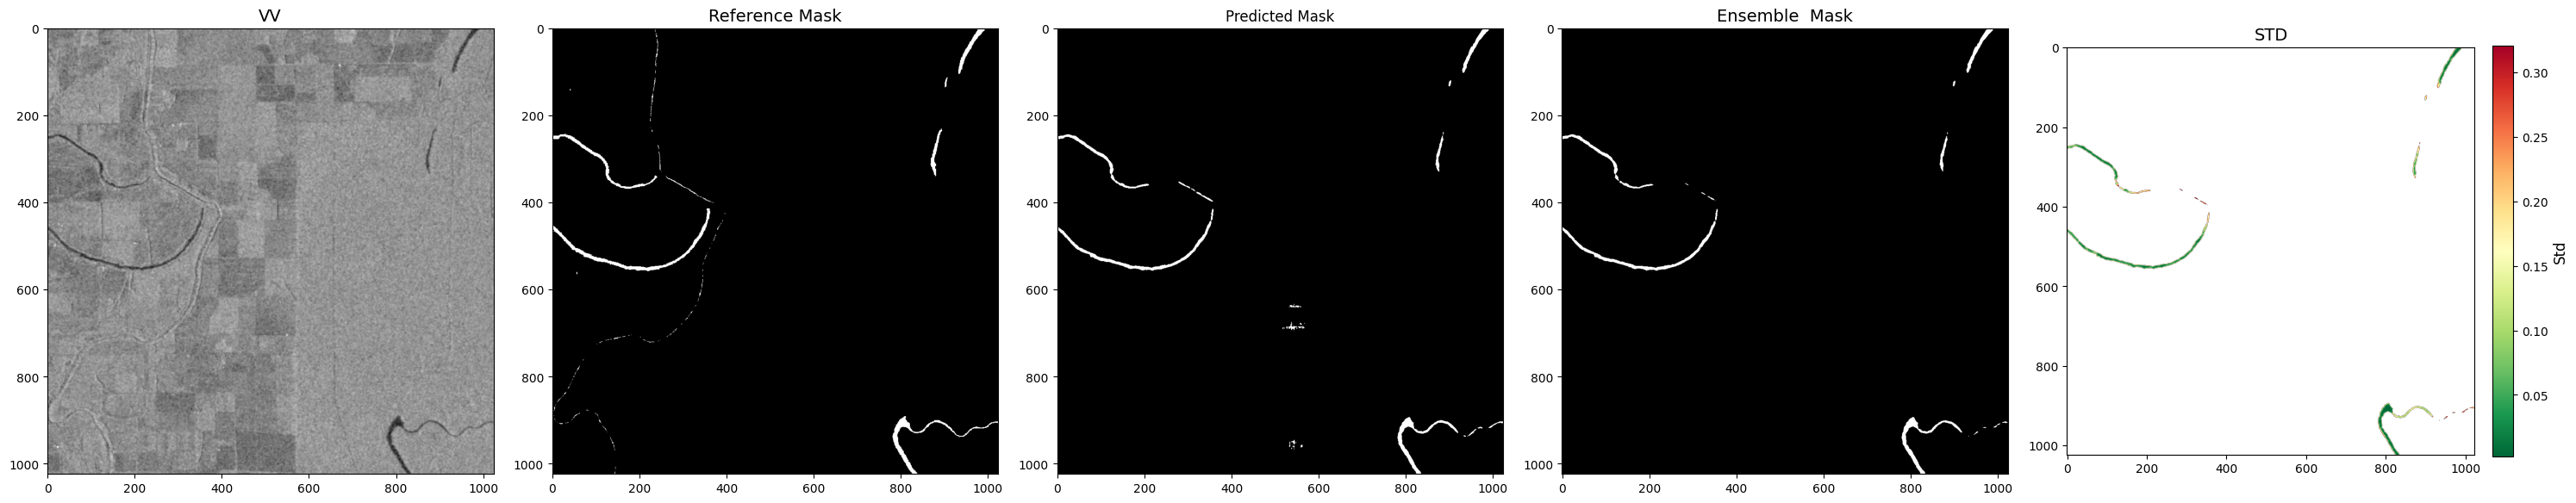

Dropout Rate: 0.2


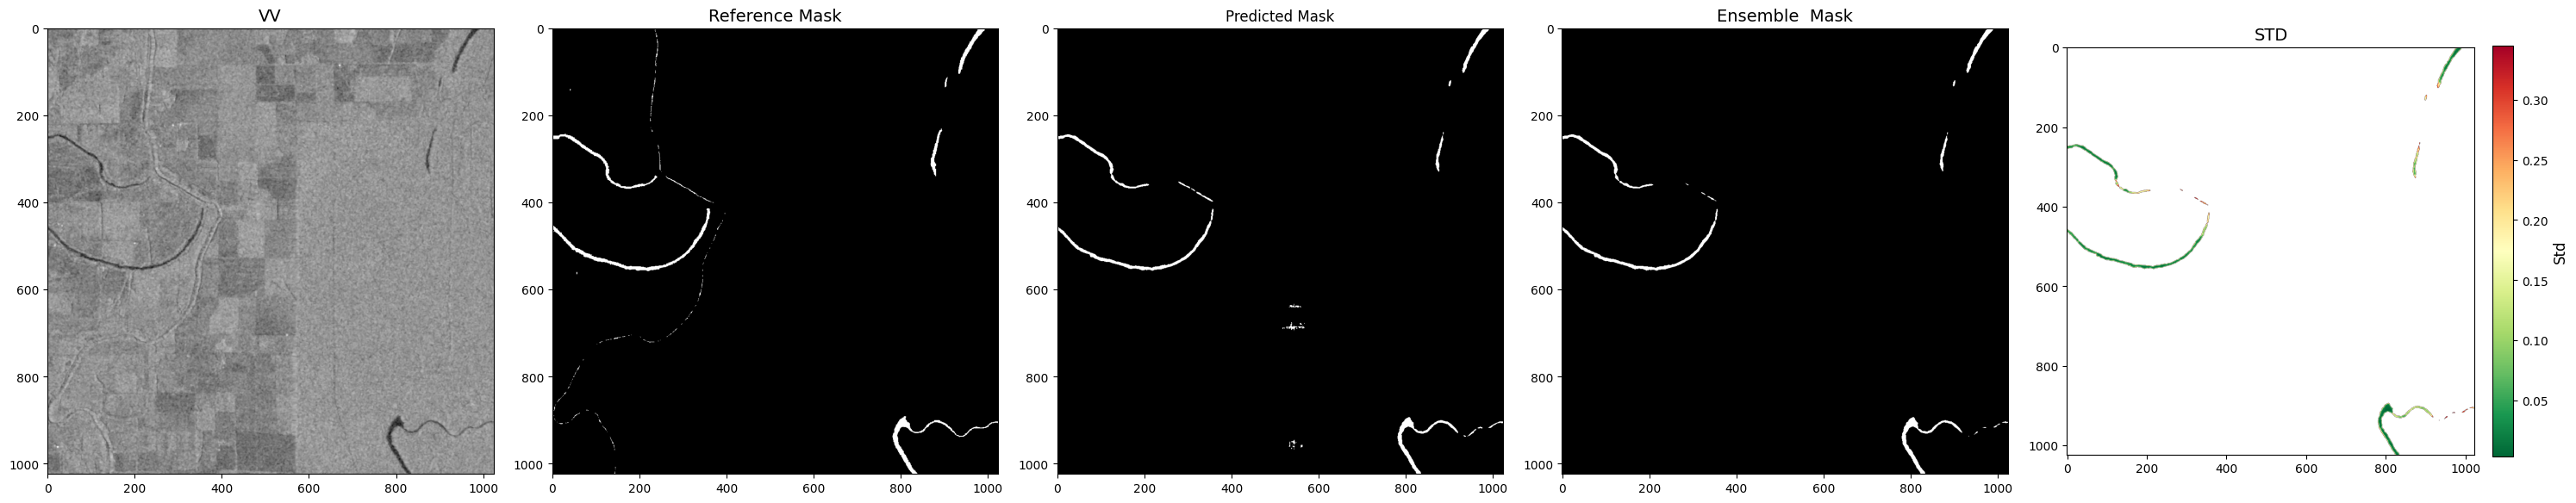

Dropout Rate: 0.25


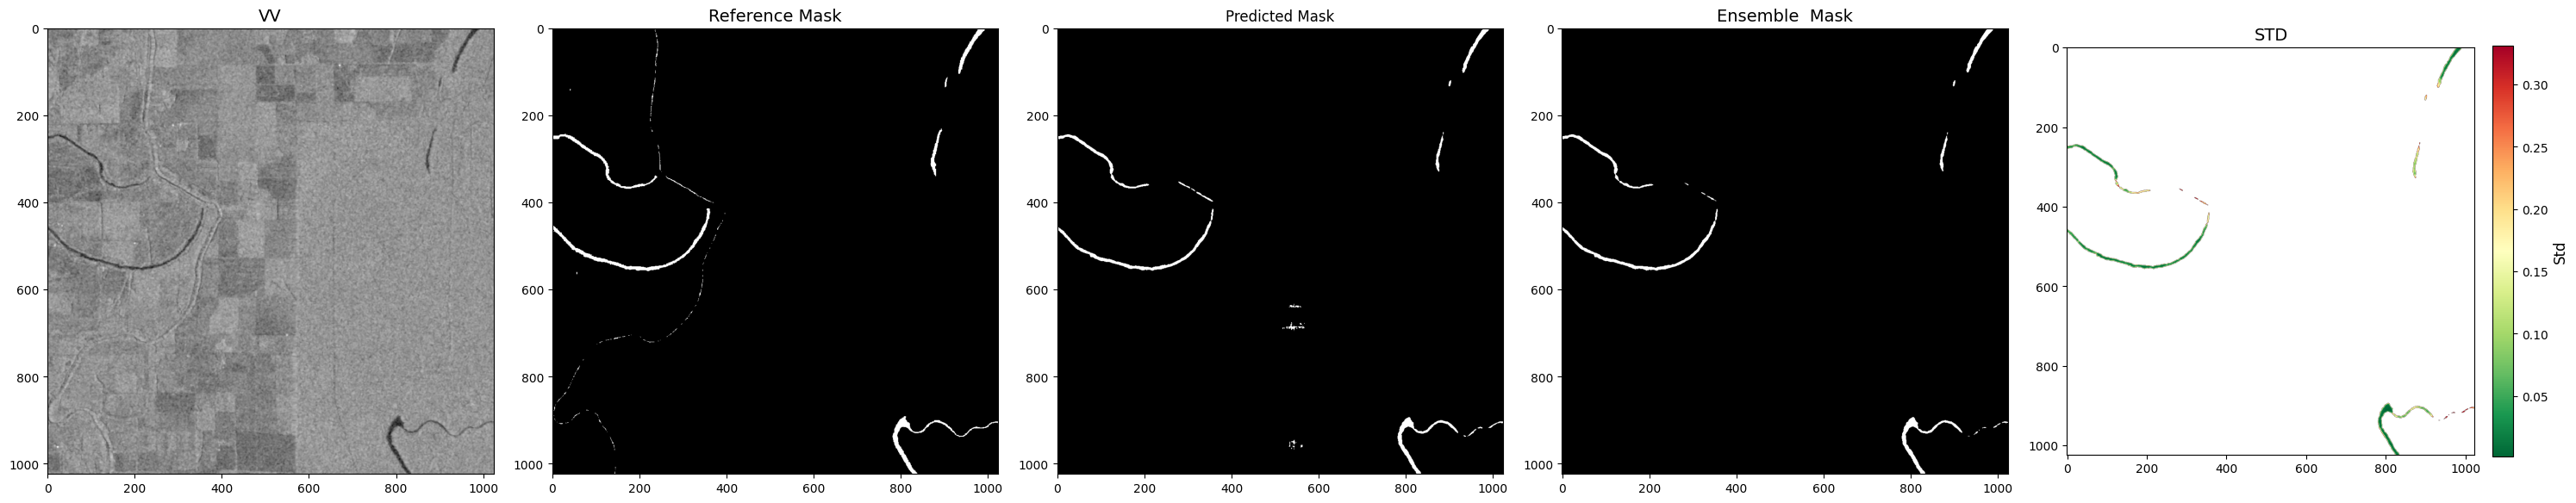

Dropout Rate: 0.30000000000000004


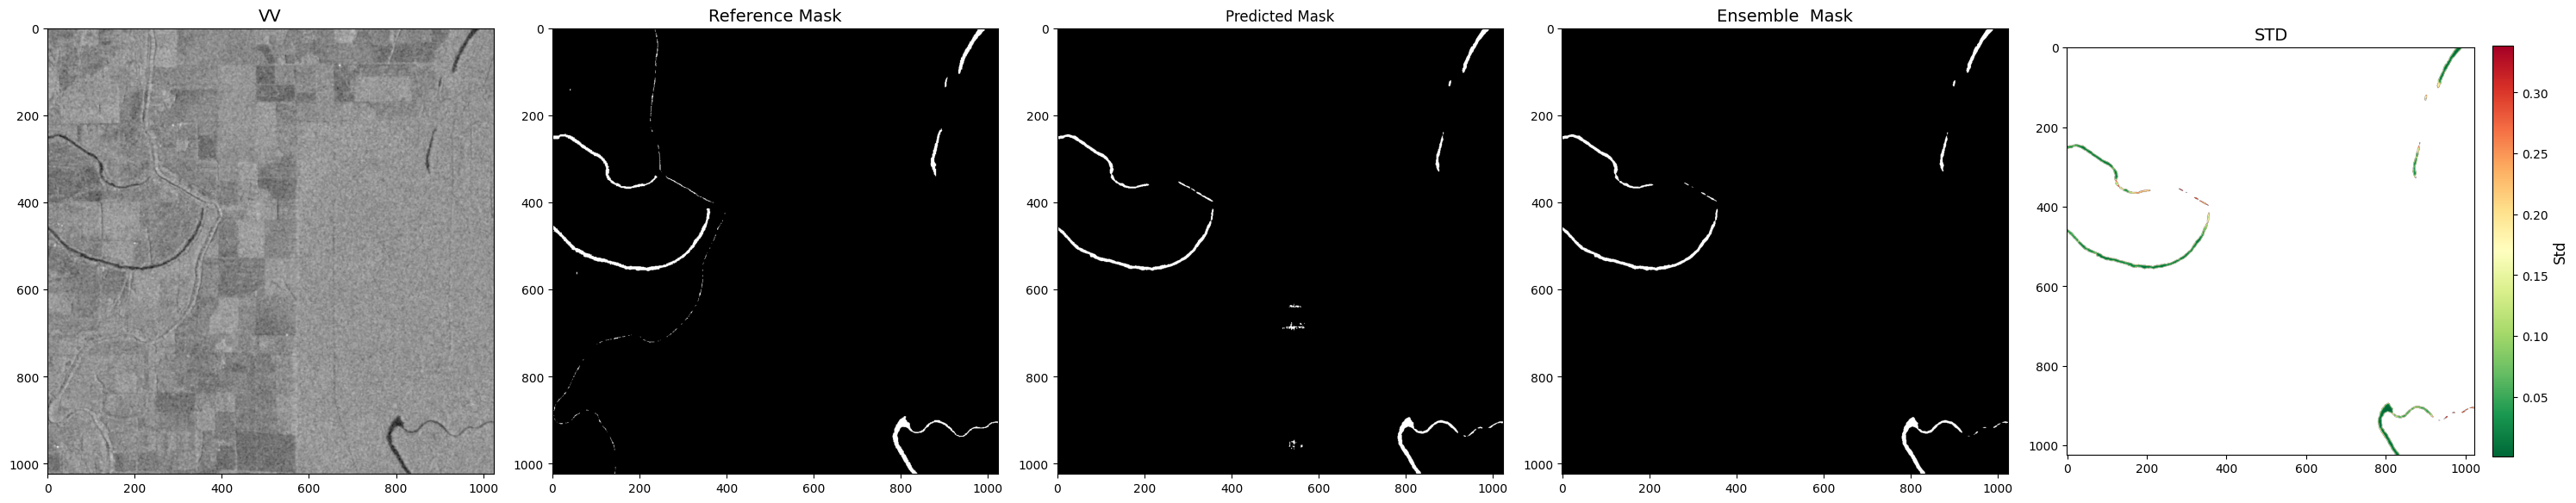

Dropout Rate: 0.35000000000000003


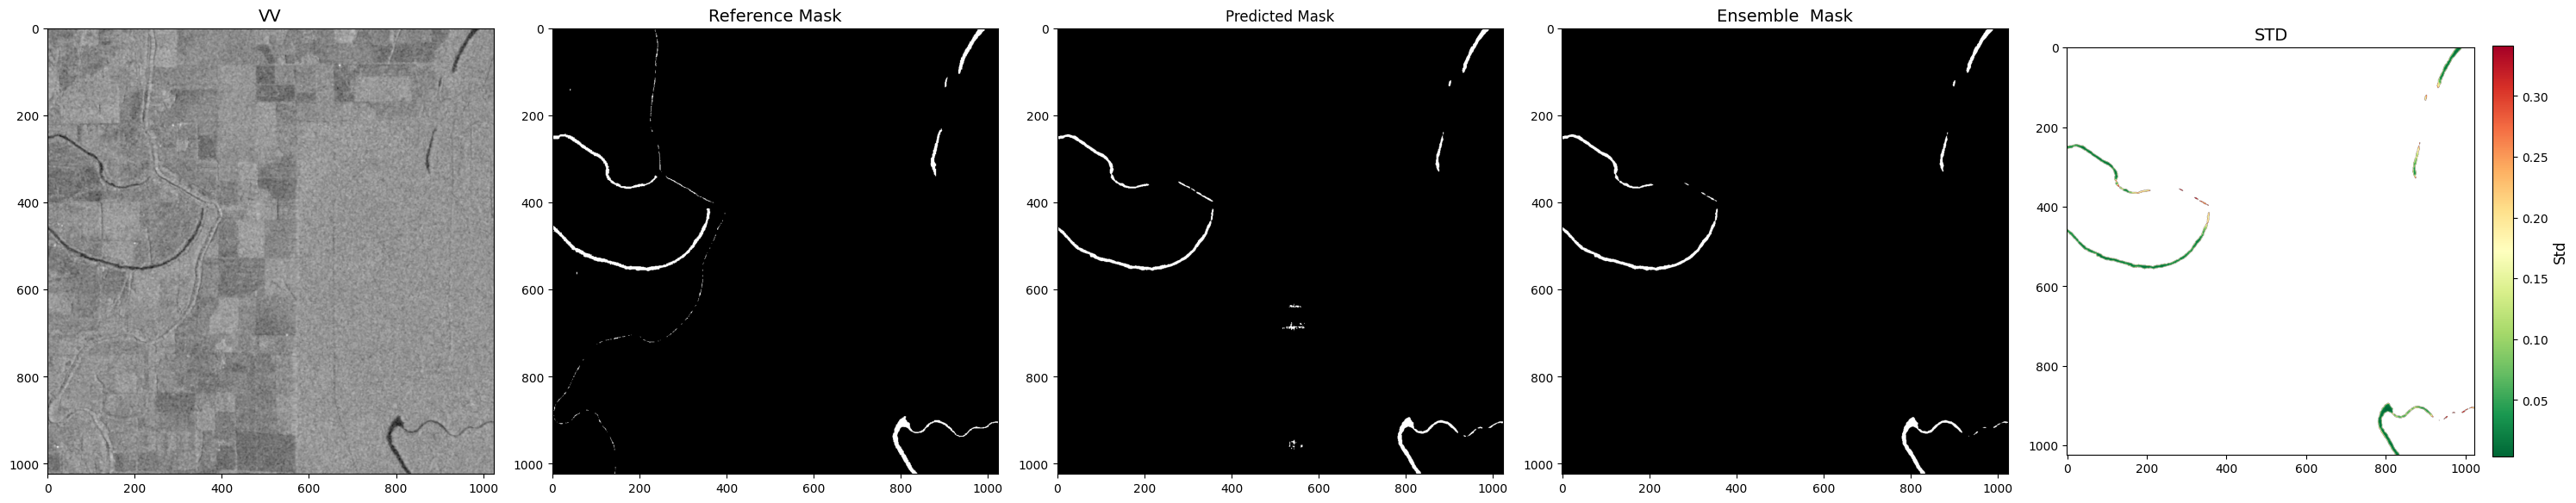

Dropout Rate: 0.4


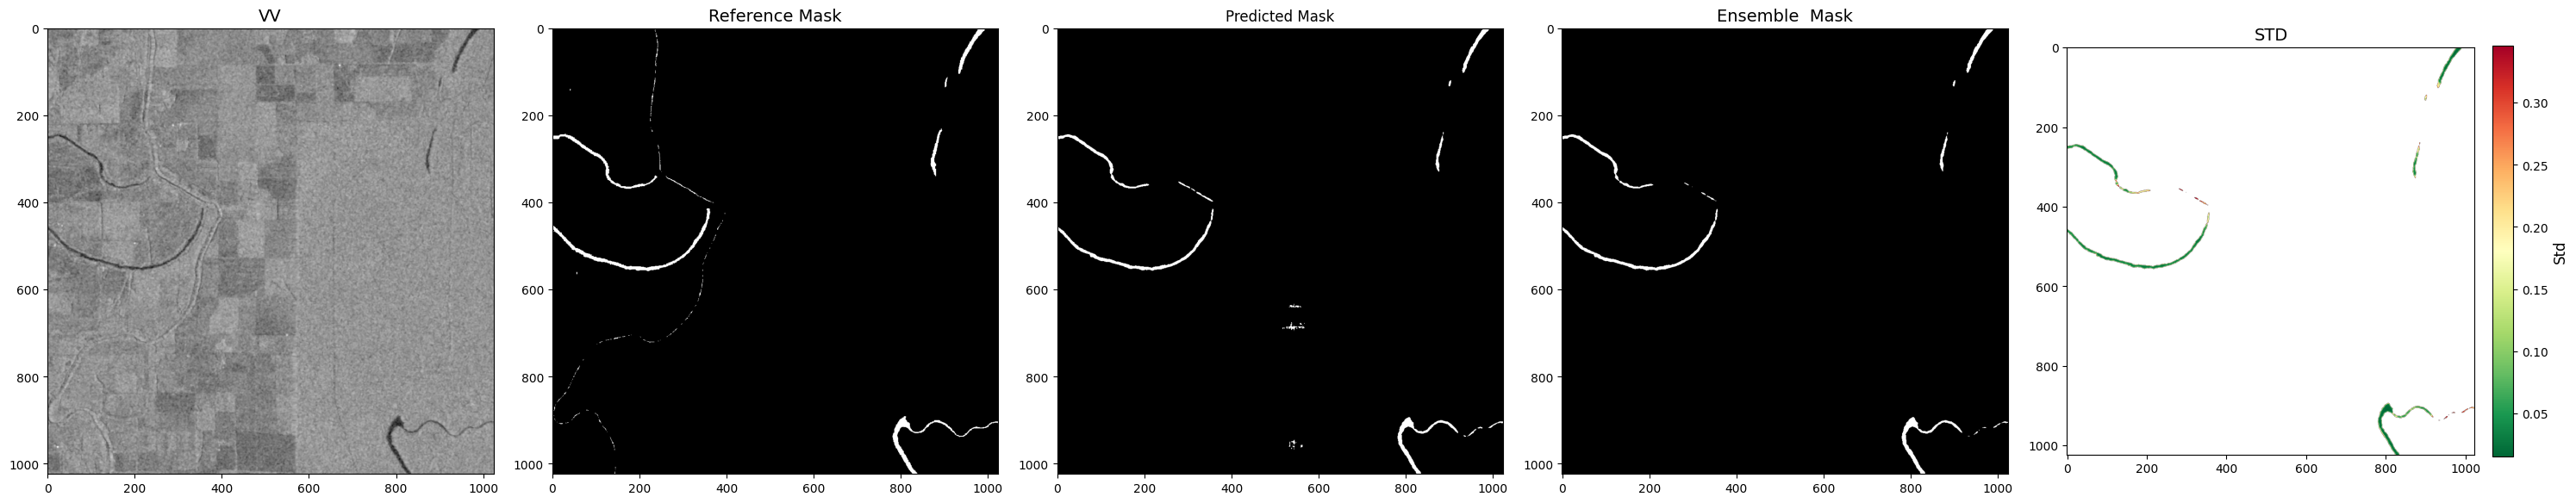

Dropout Rate: 0.45


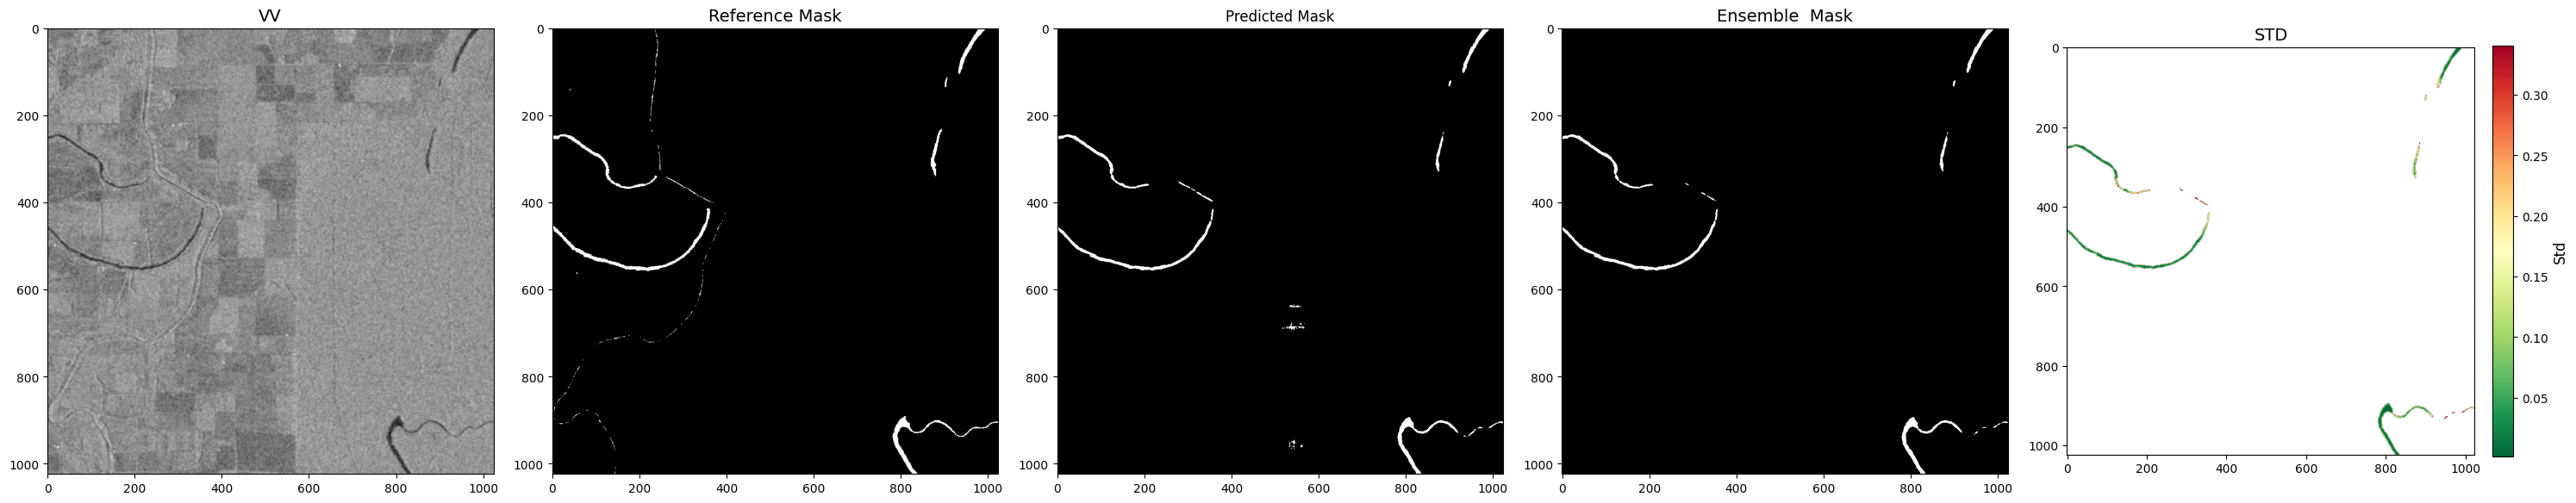

In [ ]:
for i in range(100):
    in_channels = 5 if DATASET == "s2" else 3
    device = get_device()
    model = UNet(in_channels=in_channels, out_channels=1).to(device)
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()
    rand_idx = torch.randint(0, len(test_dataset), (1,)).item()
    #print(f"Random index: {rand_idx}")
    img, mask = test_dataset[rand_idx]
    img = img[0:in_channels,:,:].unsqueeze(0)
    #print(img.shape, mask.shape)
    img = img.to(device, dtype=torch.float32)
    logits = model(img)
    pred = (torch.sigmoid(logits) > 0.5).float()
    pred = pred.squeeze(0).squeeze(0).cpu().detach().numpy()

    for step in range (0,10):

        rate = step * 0.05
        print(f"Dropout Rate: {rate}")

        model = UNet(in_channels=in_channels, out_channels=1).to(device)
        model.load_state_dict(torch.load(MODEL_PATH))
        model.eval()
        model = MonteCarloDropout(model, num_forward_passes=100, dropout_rate=rate)
        img_mean, img_std = model(img)
        img_mean = img_mean.squeeze(0).squeeze(0).cpu().detach().numpy()
        img_std = img_std.squeeze(0).squeeze(0).cpu().detach().numpy()
        image = img.squeeze(0)
        image = image.permute(1, 2, 0)
        image = image.cpu().detach().numpy()
        msk = mask.cpu().detach().numpy()
    
        #print(img_mean.min(), img_mean.max())
        #print(img_std.min(), img_std.max())
        # Create a 2x2 subplot layout
        fig, ax = plt.subplots(1, 5, figsize=(30, 25))
    
        # NIR Image
        title = "VV" if DATASET == "s1" else "NIR"
        band = 0 if DATASET == "s1" else 3
        ax[0].imshow(image[..., [band]], cmap="gray")
        ax[0].set_title(title, fontsize=14)
    
        # Reference Mask
        ax[1].imshow(msk, cmap="gray")
        ax[1].set_title("Reference Mask", fontsize=14)
    
        ax[2].imshow(pred, cmap="gray")
        ax[2].set_title("Predicted Mask")
    
        # Mean Prediction (Binarized)
        img_mean = img_mean >= 0.5
        ax[3].imshow(img_mean, cmap="gray")
        ax[3].set_title("Ensemble  Mask", fontsize=14)
        img_std[img_mean != 1] = np.nan  # Mask non-mean pixels
        # Plot STD with colormap
        im = ax[4].imshow(img_std, cmap="RdYlGn_r")
        ax[4].set_title("STD", fontsize=14)
    
        # Add colorbar to the STD plot
        cbar = fig.colorbar(im, ax=ax[4], fraction=0.046, pad=0.04)
        cbar.set_label("Std", fontsize=12)
    
        # Adjust layout and show the plot
        plt.tight_layout()
        plt.show()
    
    break